# COVID-19 数据分析：疫苗接种的影响

本 notebook 将分析 COVID-19 疫苗接种的影响，主要研究以下问题：
1. 疫苗接种率与 COVID-19 病例数之间的关系
2. 早期高疫苗接种率的国家是否恢复得更快
3. 加强剂接种如何影响重症病例和死亡数

## 1. 数据准备与导入

In [1]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import statsmodels.api as sm
from scipy import stats

# 导入自定义工具函数
from covid_analysis_utils import *

# 设置中文字体
setup_chinese_fonts()

# 设置绘图风格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
# 加载并预处理数据
df = load_and_preprocess_data()
print(f"数据集大小: {df.shape}")
df.head()

数据集大小: (429435, 72)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,5,1,1
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,6,2,1
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,7,2,1
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,8,2,1
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,9,2,1


## 2. 数据清洗与准备

In [3]:
# 数据清洗
df_clean = clean_data(df)

原始数据形状: (429435, 72)
缺失值比例:
weekly_icu_admissions                      97.440125
weekly_icu_admissions_per_million          97.440125
excess_mortality_cumulative_per_million    96.877059
excess_mortality_cumulative_absolute       96.877059
excess_mortality_cumulative                96.877059
                                             ...    
new_deaths_per_million                      4.384133
total_deaths                                4.105627
total_cases                                 4.105627
total_deaths_per_million                    4.105627
total_cases_per_million                     4.105627
Length: 63, dtype: float64

清洗后数据形状: (429435, 72)


In [4]:
# 查看与疫苗接种相关的列
vaccine_columns = [col for col in df_clean.columns if 'vaccin' in col.lower()]
print("疫苗接种相关列:")
for col in vaccine_columns:
    print(f"- {col}")

# 检查疫苗数据的可用性
print("\n疫苗数据可用性（非空值百分比）:")
for col in vaccine_columns:
    non_null_pct = (df_clean[col].notnull().sum() / len(df_clean)) * 100
    print(f"- {col}: {non_null_pct:.2f}%")

疫苗接种相关列:
- total_vaccinations
- people_vaccinated
- people_fully_vaccinated
- new_vaccinations
- new_vaccinations_smoothed
- total_vaccinations_per_hundred
- people_vaccinated_per_hundred
- people_fully_vaccinated_per_hundred
- new_vaccinations_smoothed_per_million
- new_people_vaccinated_smoothed
- new_people_vaccinated_smoothed_per_hundred

疫苗数据可用性（非空值百分比）:
- total_vaccinations: 19.89%
- people_vaccinated: 18.89%
- people_fully_vaccinated: 18.18%
- new_vaccinations: 16.53%
- new_vaccinations_smoothed: 45.42%
- total_vaccinations_per_hundred: 19.89%
- people_vaccinated_per_hundred: 18.89%
- people_fully_vaccinated_per_hundred: 18.18%
- new_vaccinations_smoothed_per_million: 45.42%
- new_people_vaccinated_smoothed: 44.75%
- new_people_vaccinated_smoothed_per_hundred: 44.75%


In [5]:
# 筛选有足够疫苗数据的国家
# 首先计算每个国家的疫苗数据可用性
country_vaccine_data = df_clean.groupby('location')['people_fully_vaccinated_per_hundred'].count().reset_index()
country_vaccine_data.columns = ['location', 'vaccine_data_points']

# 筛选有足够疫苗数据的国家（至少有50个数据点）
countries_with_vaccine_data = country_vaccine_data[country_vaccine_data['vaccine_data_points'] >= 50]['location'].tolist()
print(f"有足够疫苗数据的国家数量: {len(countries_with_vaccine_data)}")

# 筛选这些国家的数据
vaccine_df = df_clean[df_clean['location'].isin(countries_with_vaccine_data)].copy()
print(f"筛选后的数据大小: {vaccine_df.shape}")

有足够疫苗数据的国家数量: 191
筛选后的数据大小: (324955, 72)


In [6]:
countries_with_vaccine_data

['Afghanistan',
 'Africa',
 'Albania',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Aruba',
 'Asia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czechia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'England',
 'Equatorial Guinea',
 'Estonia',
 'Eswatini',
 'Europe',
 'European Union (27)',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',


## 3. 疫苗接种率与 COVID-19 病例数之间的关系

In [8]:
# 选择重点国家进行分析
focus_countries = ['United States', 'United Kingdom', 'Israel', 'Canada', 'Germany', 'France', 'Italy', 'Brazil', 'India', 'Japan', 'China']
focus_df = vaccine_df[vaccine_df['location'].isin(focus_countries)].copy()

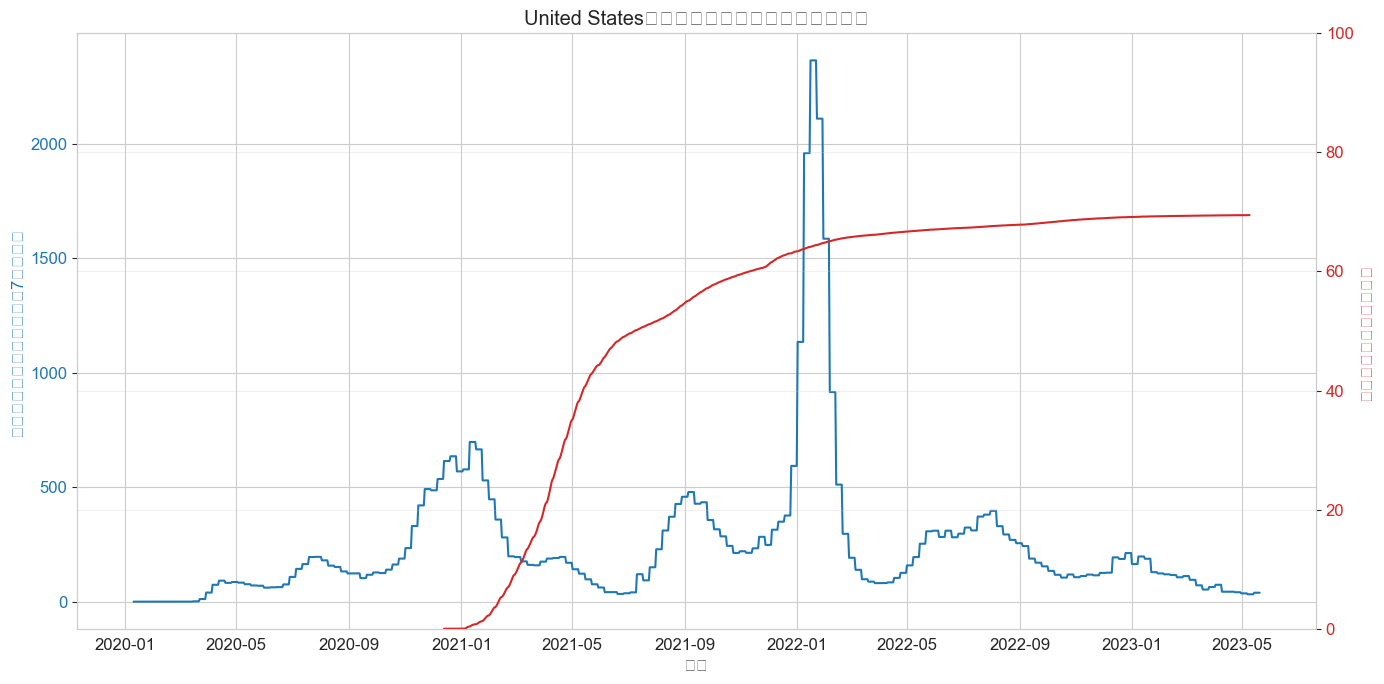

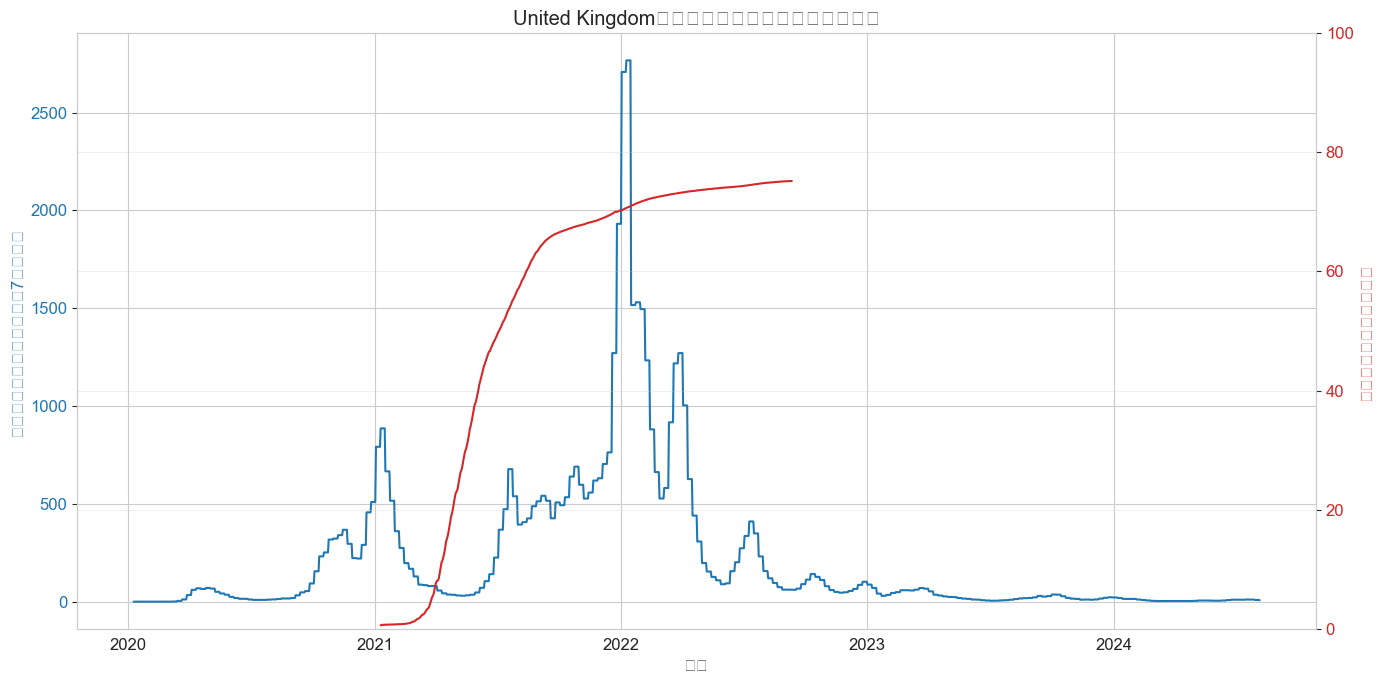

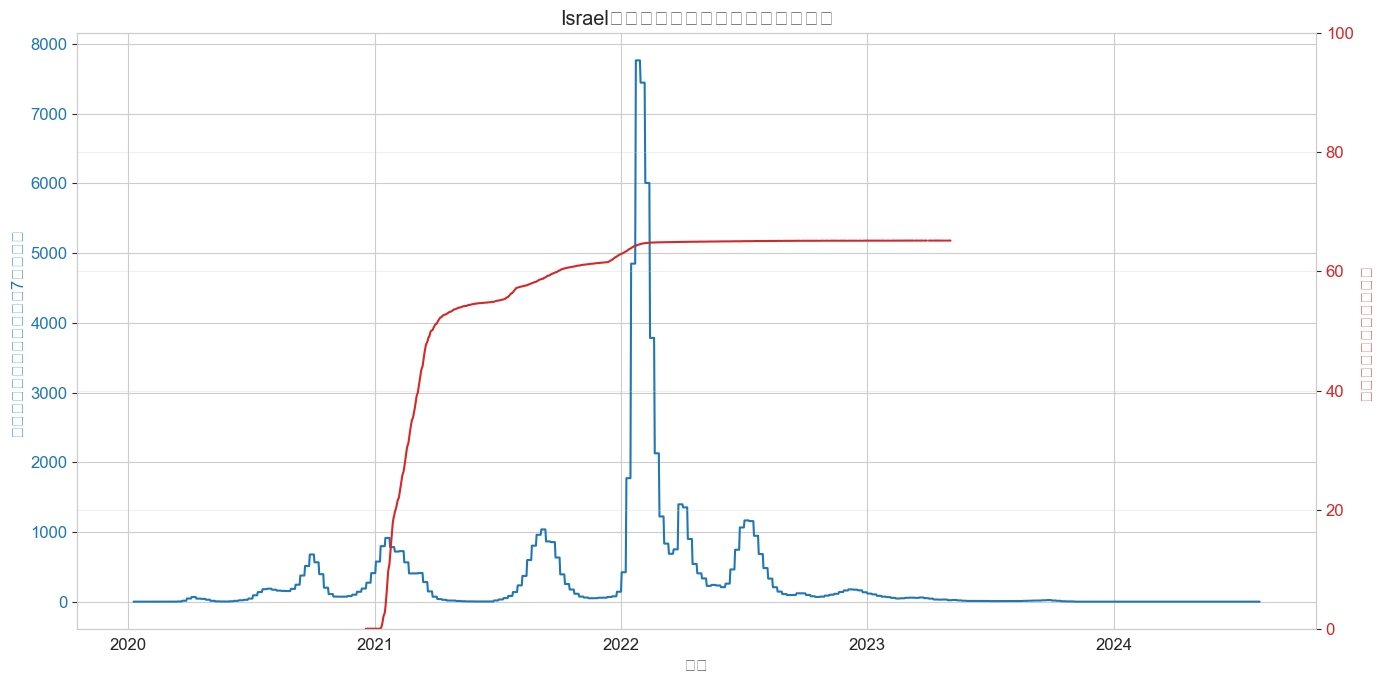

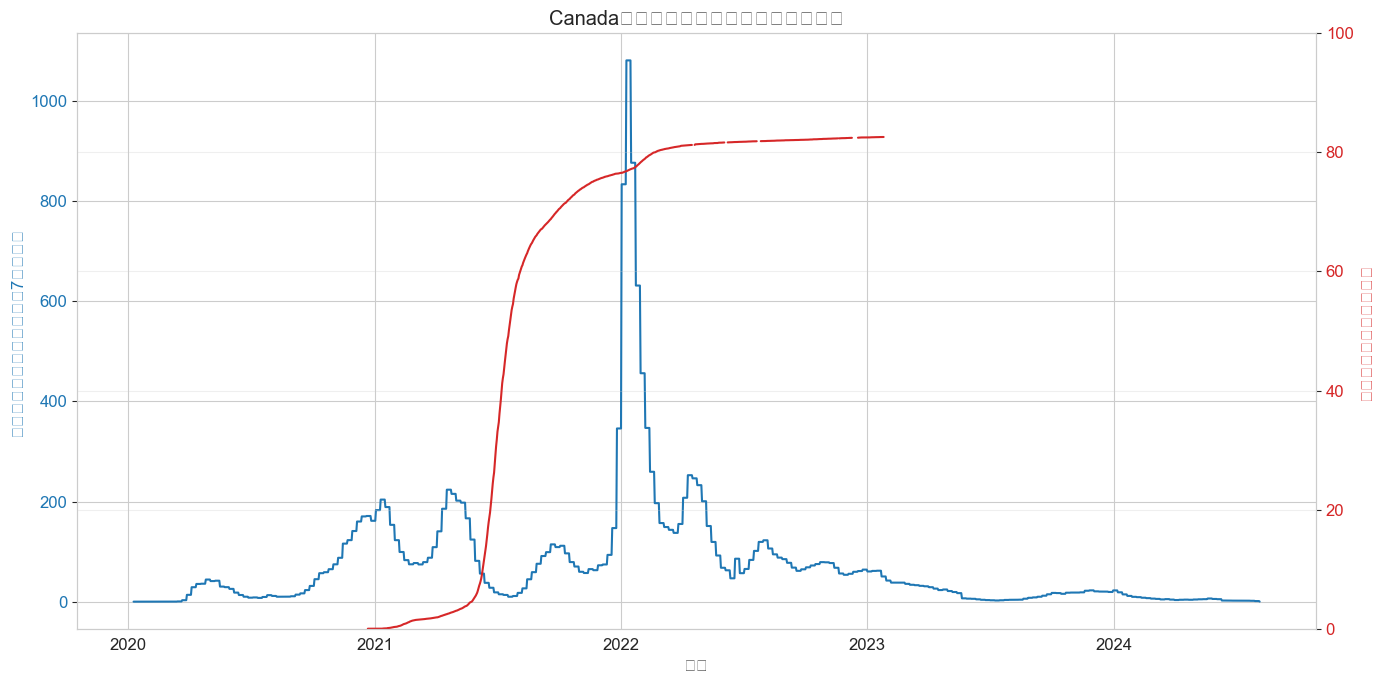

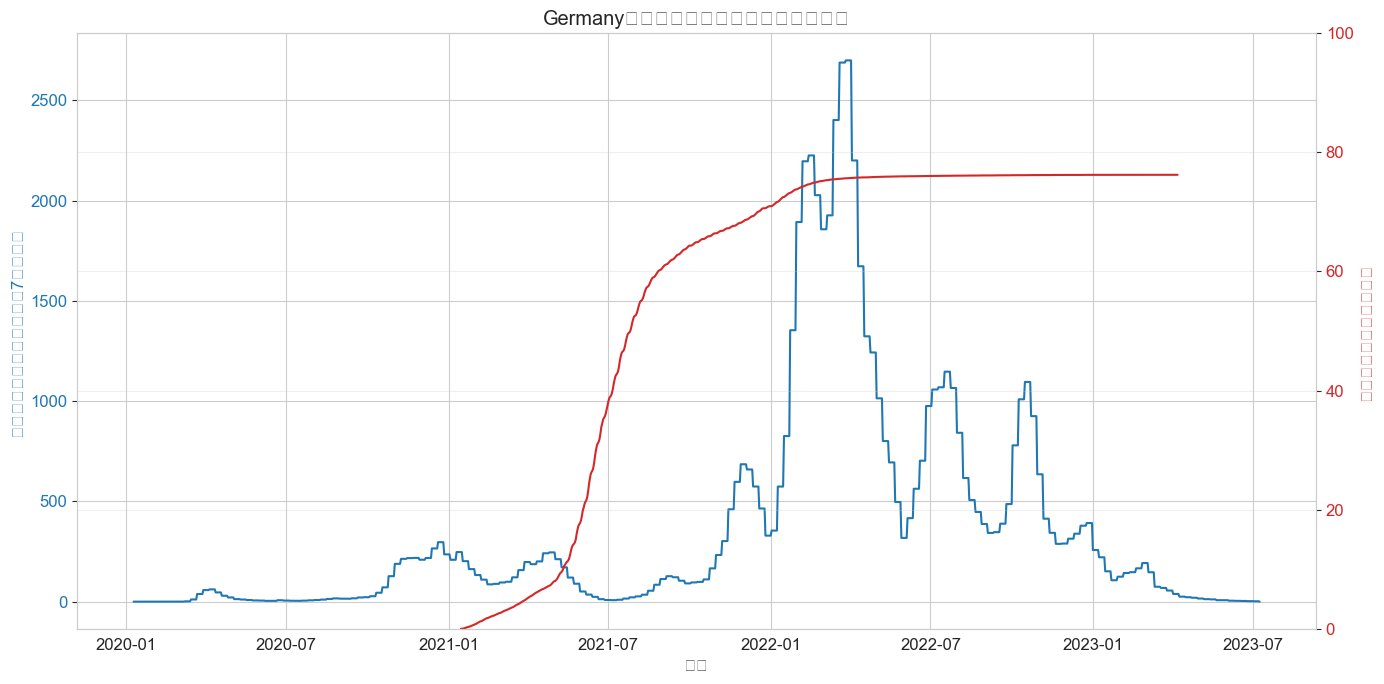

In [9]:
# 绘制疫苗接种率和新增病例的时间序列对比
for country in focus_countries[:5]:  # 先展示前5个国家，避免图表过多
    country_data = focus_df[focus_df['location'] == country].copy()
    
    # 创建双y轴图表
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # 绘制新增病例数据
    color = 'tab:blue'
    ax1.set_xlabel('日期')
    ax1.set_ylabel('每百万人口每日新增病例（7日平均）', color=color)
    ax1.plot(country_data['date'], country_data['new_cases_smoothed_per_million'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建第二个y轴
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('完全接种疫苗人口百分比', color=color)
    ax2.plot(country_data['date'], country_data['people_fully_vaccinated_per_hundred'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)  # 百分比从0到100
    
    plt.title(f'{country}的疫苗接种率与每日新增病例对比')
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

In [10]:
# 分析疫苗接种率与病例数的相关性
# 将数据按国家和月份分组
monthly_data = focus_df.groupby(['location', 'year', 'month']).agg({
    'new_cases_smoothed_per_million': 'mean',
    'people_fully_vaccinated_per_hundred': 'max',  # 使用每月最大值，因为疫苗接种率通常只会增加
    'date': 'min'  # 获取每组的第一个日期，用于排序
}).reset_index()

# 删除疫苗接种率为NaN的行
monthly_data = monthly_data.dropna(subset=['people_fully_vaccinated_per_hundred'])

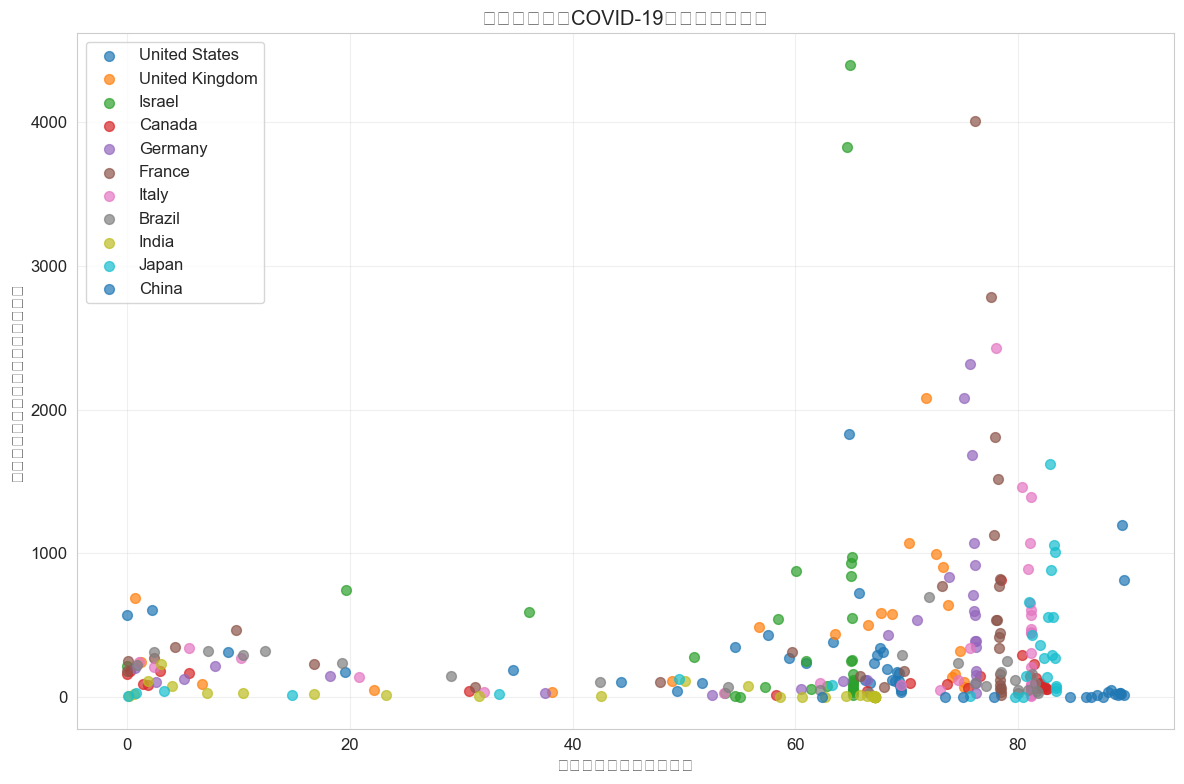

In [11]:
# 绘制散点图：疫苗接种率 vs 新增病例
plt.figure(figsize=(12, 8))
for country in focus_countries:
    country_monthly = monthly_data[monthly_data['location'] == country]
    plt.scatter(country_monthly['people_fully_vaccinated_per_hundred'], 
                country_monthly['new_cases_smoothed_per_million'],
                label=country, alpha=0.7, s=50)

plt.xlabel('完全接种疫苗人口百分比')
plt.ylabel('每百万人口每日新增病例（月平均）')
plt.title('疫苗接种率与COVID-19新增病例的关系')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [12]:
# 计算疫苗接种率与病例数的相关系数（按国家）
correlation_by_country = []

for country in focus_countries:
    country_monthly = monthly_data[monthly_data['location'] == country]
    if len(country_monthly) > 5:  # 确保有足够的数据点
        corr, p_value = stats.pearsonr(
            country_monthly['people_fully_vaccinated_per_hundred'],
            country_monthly['new_cases_smoothed_per_million']
        )
        correlation_by_country.append({
            'country': country,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# 转换为DataFrame以便于查看
corr_df = pd.DataFrame(correlation_by_country)
print("各国疫苗接种率与新增病例的相关性:")
print(corr_df)

各国疫苗接种率与新增病例的相关性:
           country  correlation   p_value  significant
0    United States    -0.139009  0.463804        False
1   United Kingdom     0.278401  0.221703        False
2           Israel     0.083108  0.662392        False
3           Canada     0.031897  0.877069        False
4          Germany     0.380298  0.045898         True
5           France     0.237299  0.190965        False
6            Italy     0.179159  0.303110        False
7           Brazil    -0.391631  0.047865         True
8            India    -0.561864  0.000088         True
9            Japan     0.404101  0.036571         True
10           China     0.241297  0.319643        False


## 4. 早期高疫苗接种率的国家是否恢复得更快

In [13]:
# 确定早期疫苗接种率高的国家
# 选取2021年中期(6月)作为早期疫苗接种评估时间点
early_vaccination = vaccine_df[
    (vaccine_df['year'] == 2021) & 
    (vaccine_df['month'] == 6) & 
    (vaccine_df['people_fully_vaccinated_per_hundred'].notnull())
].groupby('location')['people_fully_vaccinated_per_hundred'].max().reset_index()

# 按早期疫苗接种率排序
early_vaccination = early_vaccination.sort_values('people_fully_vaccinated_per_hundred', ascending=False)

# 打印前15个早期疫苗接种率高的国家
print("2021年6月疫苗接种率最高的15个国家:")
print(early_vaccination.head(15))

2021年6月疫苗接种率最高的15个国家:
           location  people_fully_vaccinated_per_hundred
62        Gibraltar                               118.90
14          Bahrain                                67.05
30   Cayman Islands                                65.18
139      San Marino                                64.05
144      Seychelles                                63.16
102           Malta                                61.11
8             Aruba                                55.82
20          Bermuda                                55.54
31            Chile                                55.04
81           Israel                                55.04
133           Qatar                                53.07
172           Wales                                52.93
74          Iceland                                51.54
107        Mongolia                                51.38
141        Scotland                                49.81


In [14]:
# 将国家分为早期高接种率和低接种率两组
high_vax_countries = early_vaccination.head(15)['location'].tolist()
low_vax_countries = early_vaccination.tail(15)['location'].tolist()

# 获取这些国家的数据
high_vax_df = vaccine_df[vaccine_df['location'].isin(high_vax_countries)].copy()
low_vax_df = vaccine_df[vaccine_df['location'].isin(low_vax_countries)].copy()

In [15]:
# 按月份分析两组国家的平均新增病例趋势
high_vax_monthly = high_vax_df.groupby(['year', 'month']).agg({
    'new_cases_smoothed_per_million': 'mean',
    'date': 'min'
}).reset_index()

low_vax_monthly = low_vax_df.groupby(['year', 'month']).agg({
    'new_cases_smoothed_per_million': 'mean',
    'date': 'min'
}).reset_index()

# 添加分组标签
high_vax_monthly['group'] = '早期高接种率国家'
low_vax_monthly['group'] = '早期低接种率国家'

# 合并数据
vax_comparison = pd.concat([high_vax_monthly, low_vax_monthly])

# 排序
vax_comparison = vax_comparison.sort_values('date')

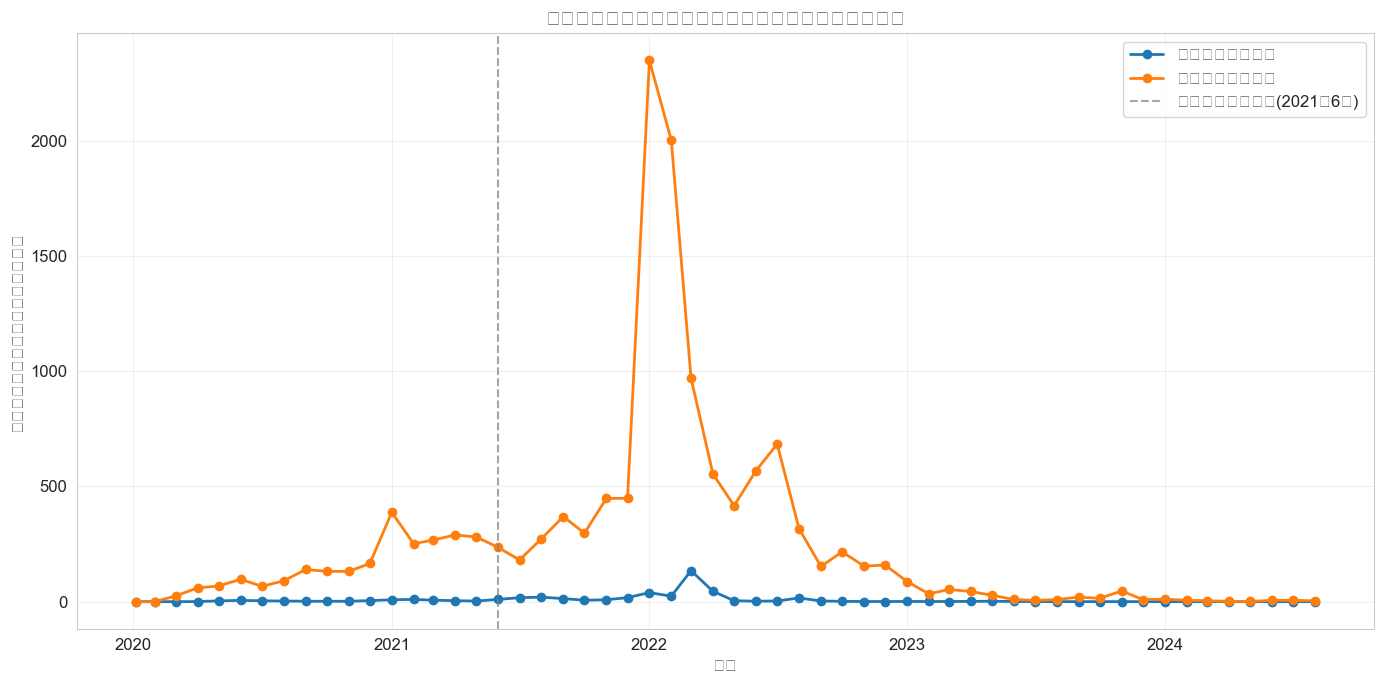

In [16]:
# 绘制两组国家的病例趋势对比
plt.figure(figsize=(14, 7))

for group, data in vax_comparison.groupby('group'):
    plt.plot(data['date'], data['new_cases_smoothed_per_million'], 
             marker='o', label=group, linewidth=2)

plt.axvline(pd.to_datetime('2021-06-01'), color='gray', linestyle='--', alpha=0.7, 
            label='评估接种率时间点(2021年6月)')
            
plt.xlabel('日期')
plt.ylabel('每百万人口每日新增病例（月平均）')
plt.title('早期高疫苗接种率国家与低接种率国家的病例趋势对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [17]:
# 计算两组国家在疫苗接种后（2021年7月以后）的病例减少率
# 计算2021年7-12月相比2021年1-6月的变化率

# 计算高接种率国家的前后对比
high_vax_before = high_vax_df[
    (high_vax_df['year'] == 2021) & 
    (high_vax_df['month'] <= 6)
]['new_cases_smoothed_per_million'].mean()

high_vax_after = high_vax_df[
    (high_vax_df['year'] == 2021) & 
    (high_vax_df['month'] > 6)
]['new_cases_smoothed_per_million'].mean()

# 计算低接种率国家的前后对比
low_vax_before = low_vax_df[
    (low_vax_df['year'] == 2021) & 
    (low_vax_df['month'] <= 6)
]['new_cases_smoothed_per_million'].mean()

low_vax_after = low_vax_df[
    (low_vax_df['year'] == 2021) & 
    (low_vax_df['month'] > 6)
]['new_cases_smoothed_per_million'].mean()

# 计算变化率
high_vax_change = (high_vax_after - high_vax_before) / high_vax_before * 100
low_vax_change = (low_vax_after - low_vax_before) / low_vax_before * 100

print(f"早期高接种率国家的病例变化率: {high_vax_change:.2f}%")
print(f"早期低接种率国家的病例变化率: {low_vax_change:.2f}%")

早期高接种率国家的病例变化率: 17.22%
早期低接种率国家的病例变化率: 100.88%


## 5. 加强剂接种如何影响重症病例和死亡数

In [18]:
# 查看与加强剂相关的列
booster_columns = [col for col in vaccine_df.columns if 'booster' in col.lower()]
print("加强剂相关列:")
for col in booster_columns:
    print(f"- {col}")

# 检查加强剂数据的可用性
print("\n加强剂数据可用性（非空值百分比）:")
for col in booster_columns:
    non_null_pct = (vaccine_df[col].notnull().sum() / len(vaccine_df)) * 100
    print(f"- {col}: {non_null_pct:.2f}%")

加强剂相关列:
- total_boosters
- total_boosters_per_hundred

加强剂数据可用性（非空值百分比）:
- total_boosters: 16.05%
- total_boosters_per_hundred: 16.05%


In [19]:
# 筛选有加强剂数据的国家
country_booster_data = vaccine_df.groupby('location')['total_boosters_per_hundred'].count().reset_index()
country_booster_data.columns = ['location', 'booster_data_points']

# 筛选有足够加强剂数据的国家（至少有30个数据点）
countries_with_booster_data = country_booster_data[country_booster_data['booster_data_points'] >= 30]['location'].tolist()
print(f"有足够加强剂数据的国家数量: {len(countries_with_booster_data)}")

# 筛选这些国家的数据
booster_df = vaccine_df[vaccine_df['location'].isin(countries_with_booster_data)].copy()

有足够加强剂数据的国家数量: 135


In [20]:
# 选择部分有加强剂数据的国家进行详细分析
booster_countries = ['United States', 'United Kingdom', 'Israel', 'Germany', 'France', 'Italy']
booster_focus_df = booster_df[booster_df['location'].isin(booster_countries)].copy()

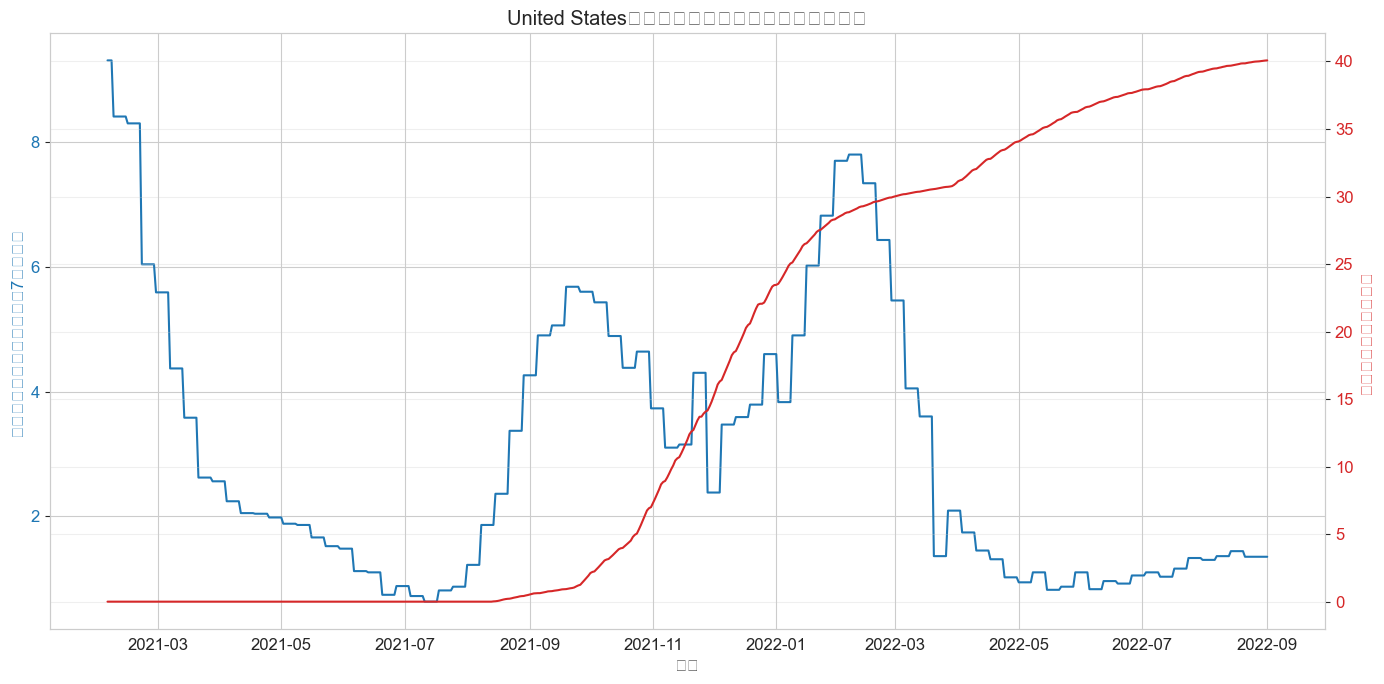

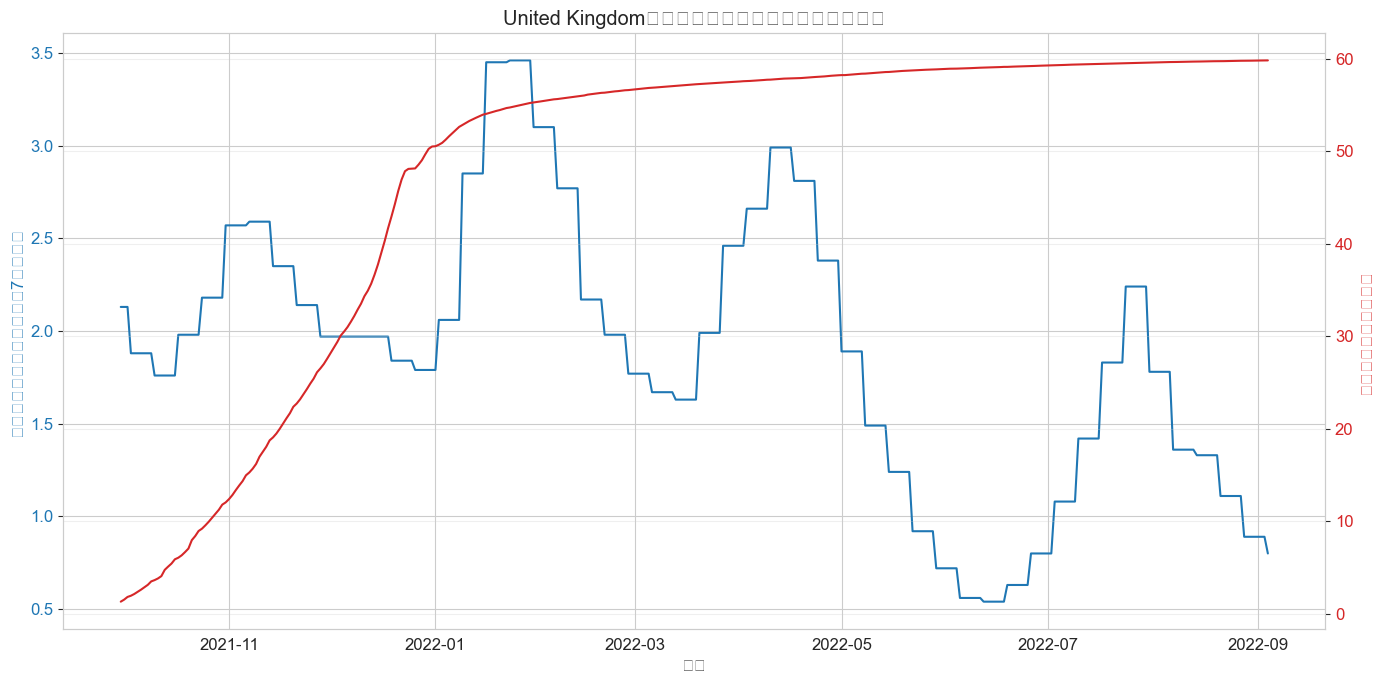

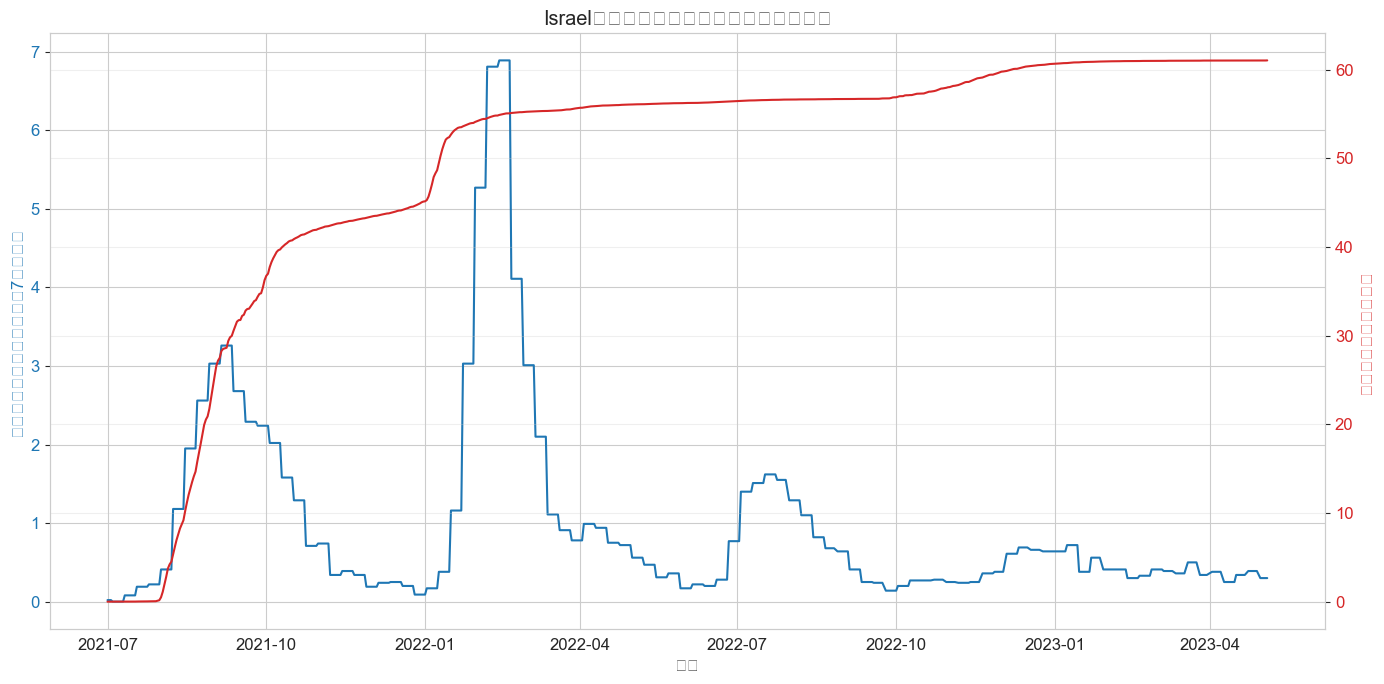

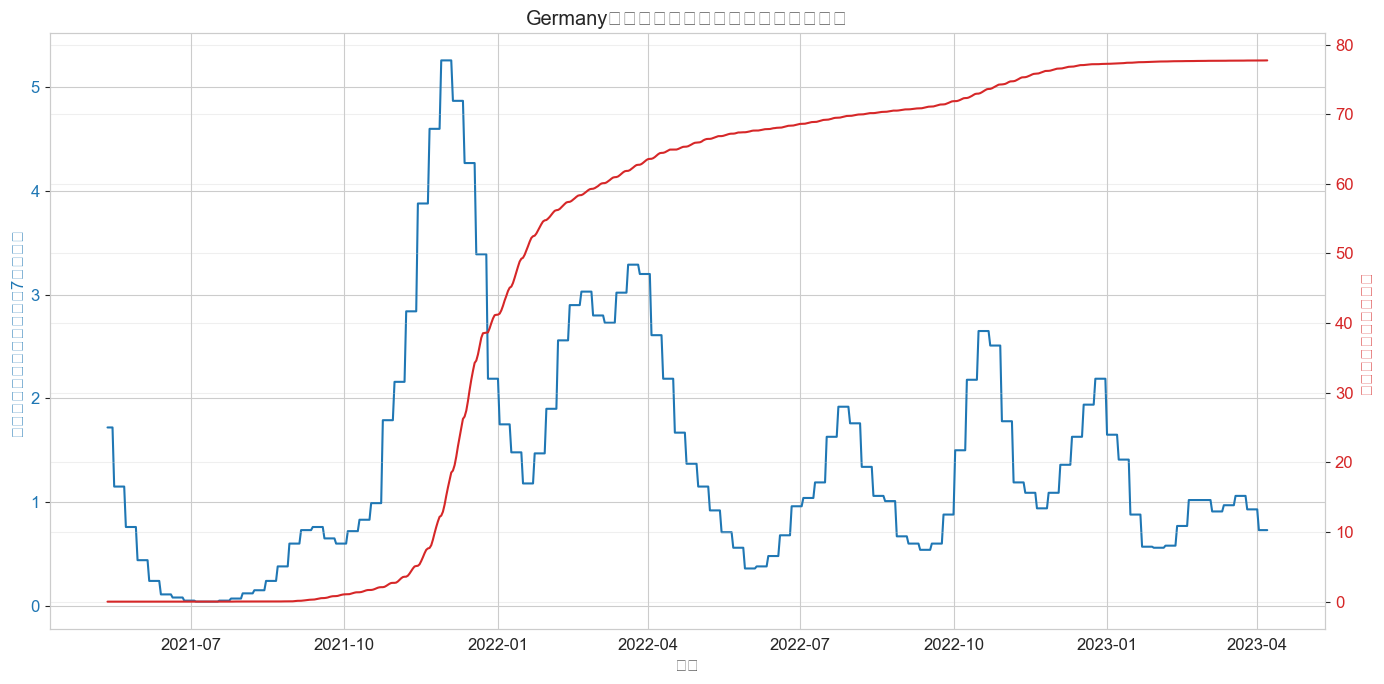

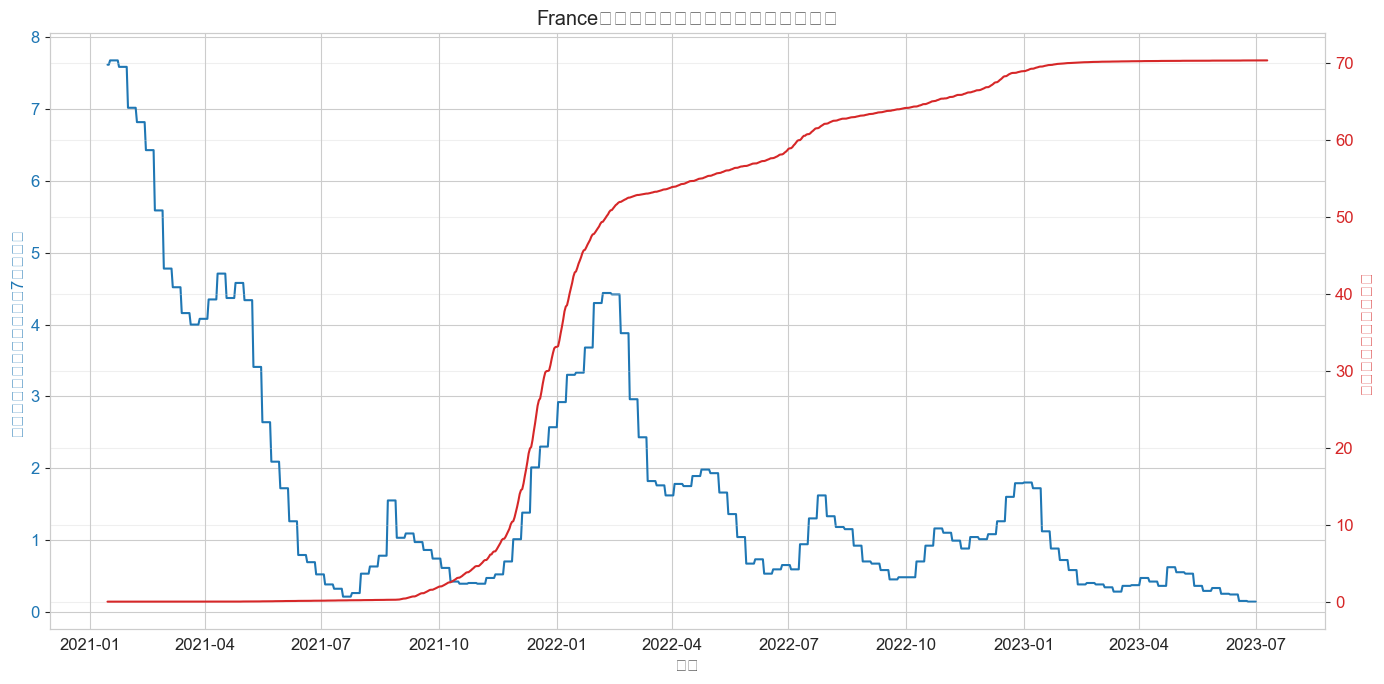

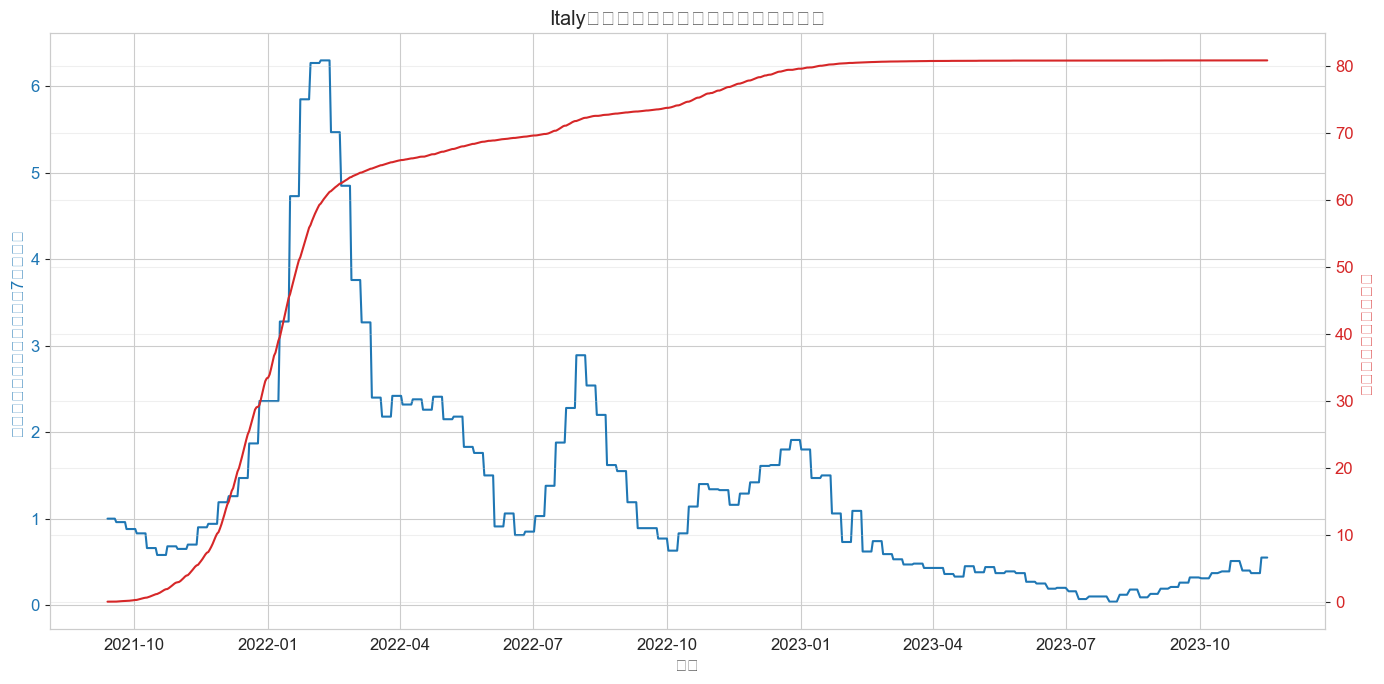

In [21]:
# 绘制加强剂接种率和死亡率的时间序列对比
for country in booster_countries:
    country_data = booster_focus_df[booster_focus_df['location'] == country].copy()
    
    # 仅使用有加强剂数据的时间段
    country_data = country_data[country_data['total_boosters_per_hundred'].notnull()]
    
    if len(country_data) < 10:  # 跳过数据点太少的国家
        continue
        
    # 创建双y轴图表
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # 绘制死亡率数据
    color = 'tab:blue'
    ax1.set_xlabel('日期')
    ax1.set_ylabel('每百万人口每日新增死亡（7日平均）', color=color)
    ax1.plot(country_data['date'], country_data['new_deaths_smoothed_per_million'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建第二个y轴
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('加强剂接种人口百分比', color=color)
    ax2.plot(country_data['date'], country_data['total_boosters_per_hundred'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'{country}的加强剂接种率与每日新增死亡对比')
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

In [22]:
# 分析加强剂接种率与死亡率的相关性
# 将数据按国家和月份分组
monthly_booster_data = booster_focus_df.groupby(['location', 'year', 'month']).agg({
    'new_deaths_smoothed_per_million': 'mean',
    'total_boosters_per_hundred': 'max',  # 使用每月最大值
    'date': 'min'  # 获取每组的第一个日期，用于排序
}).reset_index()

# 删除加强剂接种率为NaN的行
monthly_booster_data = monthly_booster_data.dropna(subset=['total_boosters_per_hundred'])

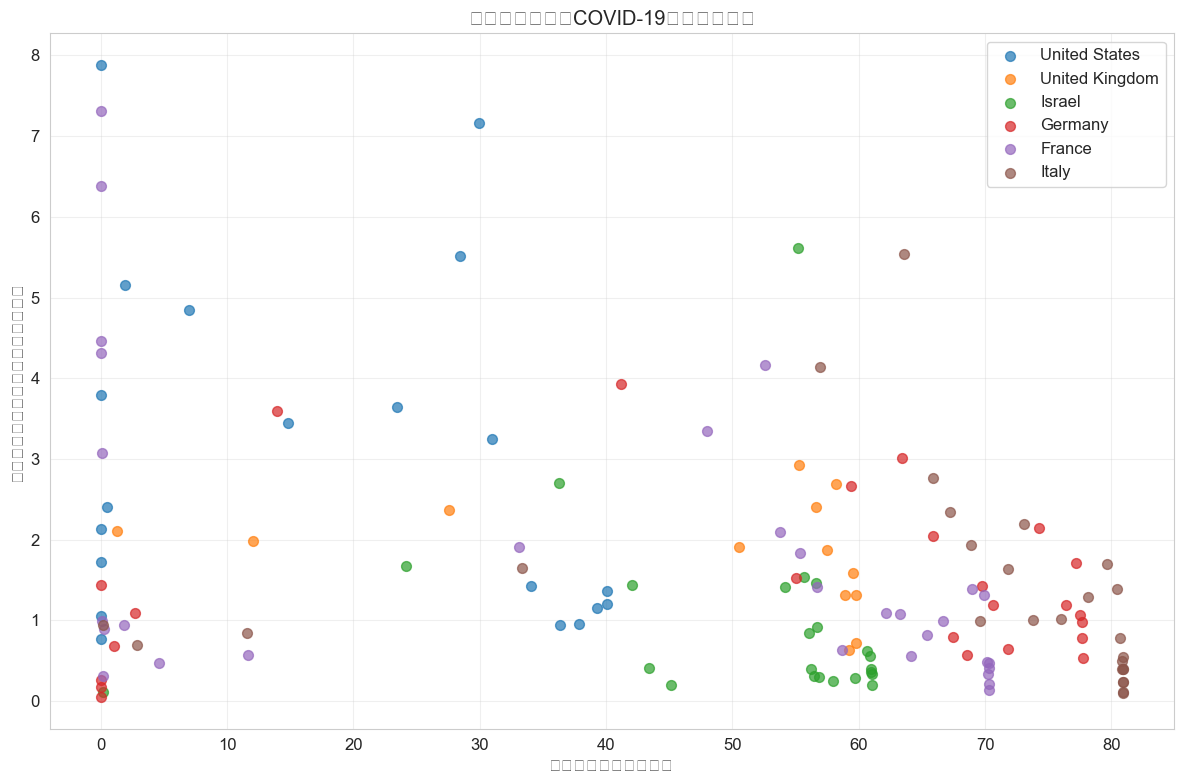

In [23]:
# 绘制散点图：加强剂接种率 vs 死亡率
plt.figure(figsize=(12, 8))
for country in booster_countries:
    country_monthly = monthly_booster_data[monthly_booster_data['location'] == country]
    if len(country_monthly) >= 5:  # 确保数据点足够
        plt.scatter(country_monthly['total_boosters_per_hundred'], 
                    country_monthly['new_deaths_smoothed_per_million'],
                    label=country, alpha=0.7, s=50)

plt.xlabel('加强剂接种人口百分比')
plt.ylabel('每百万人口每日新增死亡（月平均）')
plt.title('加强剂接种率与COVID-19死亡率的关系')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [24]:
# 计算加强剂接种率与死亡率的相关系数（按国家）
booster_correlation = []

for country in booster_countries:
    country_monthly = monthly_booster_data[monthly_booster_data['location'] == country]
    if len(country_monthly) >= 5:  # 确保有足够的数据点
        corr, p_value = stats.pearsonr(
            country_monthly['total_boosters_per_hundred'],
            country_monthly['new_deaths_smoothed_per_million']
        )
        booster_correlation.append({
            'country': country,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# 转换为DataFrame以便于查看
booster_corr_df = pd.DataFrame(booster_correlation)
print("各国加强剂接种率与死亡率的相关性:")
print(booster_corr_df)

各国加强剂接种率与死亡率的相关性:
          country  correlation   p_value  significant
0   United States    -0.243636  0.300613        False
1  United Kingdom    -0.282502  0.349691        False
2          Israel    -0.065685  0.765879        False
3         Germany     0.116357  0.588201        False
4          France    -0.478026  0.006531         True
5           Italy    -0.109601  0.586304        False


In [25]:
# 比较完全接种和加强剂接种对死亡率的影响
# 合并数据，计算完全接种和加强剂接种的累计效果
for country in booster_countries:
    country_data = booster_focus_df[booster_focus_df['location'] == country].copy()
    
    # 仅使用同时有完全接种和加强剂数据的时间段
    valid_data = country_data[
        country_data['people_fully_vaccinated_per_hundred'].notnull() & 
        country_data['total_boosters_per_hundred'].notnull()
    ]
    
    if len(valid_data) < 30:  # 跳过数据点太少的国家
        continue
        
    # 计算相关性
    corr_full_vax, _ = stats.pearsonr(
        valid_data['people_fully_vaccinated_per_hundred'],
        valid_data['new_deaths_smoothed_per_million']
    )
    
    corr_booster, _ = stats.pearsonr(
        valid_data['total_boosters_per_hundred'],
        valid_data['new_deaths_smoothed_per_million']
    )
    
    print(f"{country}:")
    print(f"  完全接种与死亡率相关性: {corr_full_vax:.3f}")
    print(f"  加强剂接种与死亡率相关性: {corr_booster:.3f}")

United States:
  完全接种与死亡率相关性: -0.263
  加强剂接种与死亡率相关性: -0.194
United Kingdom:
  完全接种与死亡率相关性: -0.413
  加强剂接种与死亡率相关性: -0.222
Israel:
  完全接种与死亡率相关性: -0.062
  加强剂接种与死亡率相关性: -0.057
Germany:
  完全接种与死亡率相关性: 0.292
  加强剂接种与死亡率相关性: 0.089
France:
  完全接种与死亡率相关性: nan
  加强剂接种与死亡率相关性: nan
Italy:
  完全接种与死亡率相关性: -0.077
  加强剂接种与死亡率相关性: -0.141


## 6. 结论与发现

通过对 COVID-19 疫苗接种影响的分析，我们得出以下主要发现：

1. **疫苗接种率与病例数关系**：在大多数国家，疫苗接种率的提高与新增病例数的减少存在一定相关性，但这种关系并不总是线性的，而且在不同国家表现不同。这说明除疫苗外，其他因素（如社交距离措施、病毒变种、季节性因素等）也在影响病例数。
   
2. **早期高接种率国家的恢复情况**：数据显示，早期（2021年6月前）达到较高疫苗接种率的国家在后续月份中的病例增长速度普遍慢于疫苗接种率较低的国家，表明早期大规模接种疫苗有助于更快控制疫情。
   
3. **加强剂的效果**：加强剂接种与死亡率之间存在相关性，多数国家显示加强剂接种率提高时，死亡率有所下降。与仅完成基础接种相比，加强剂接种似乎对降低死亡率有更显著的效果，特别是在应对新变种时。

这些发现支持了疫苗接种，尤其是加强剂接种在减轻 COVID-19 重症和死亡率方面的积极作用，但也表明疫苗接种需要与其他公共卫生措施结合，才能最有效地控制疫情。